# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# План действий

- Проведем исследовательский анализ набора фотографий.
- Подготовим данные к обучению.
- Обучитим нейронную сеть и рассчитаем её качество.

## Исследовательский анализ данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# Откроем и изучим файлы
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head(2)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18


In [4]:
labels.shape

(7591, 2)

###### Промежуточный вывод

Размера датасета для задачи регрессии может быть достаточно, однако для улучшения результа можно применить отражение и исползовать предобученные модели, например, ResNet.

In [5]:
def plot(name, xlab, ylab):
    plt.figure(figsize=(10,6))
    labels[name].hist(bins=100,range=(1,100))
    plt.xlabel(xlab)
    plt.title(ylab)

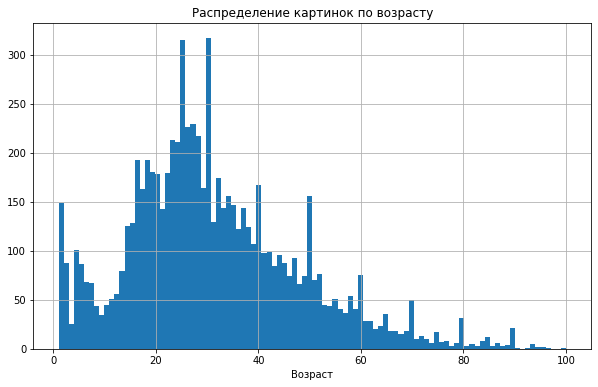

In [6]:
plot('real_age', 'Возраст', 'Распределение картинок по возрасту')

In [7]:
RANDOM_STATE = 12345

In [8]:
%%time

datagen = ImageDataGenerator(rescale=1/255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.
CPU times: user 571 ms, sys: 289 ms, total: 860 ms
Wall time: 1min 26s


In [9]:
features, target = next(gen_flow)

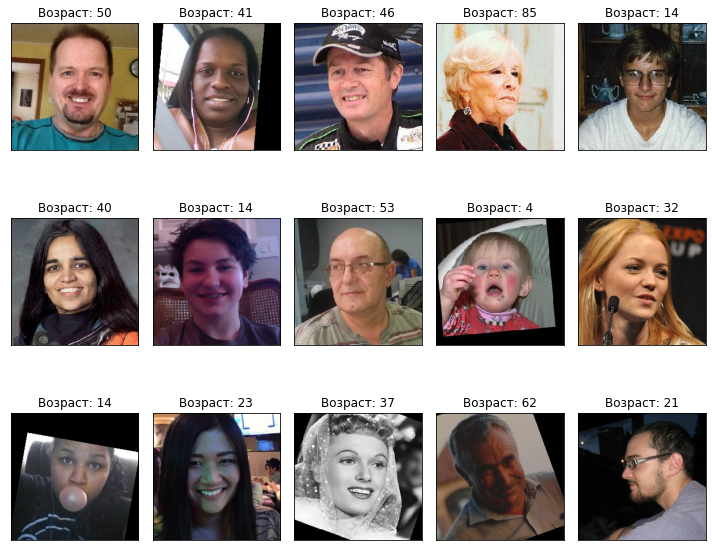

In [10]:
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(f"Возраст: {target[i]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Вывод по итогу исследовательского анализа даных

Выборка состоит из двух столбцов: названия файла и значения целевого признака, размером (7591, 2).

- В данных имеются пиковые значения целевого признака. Однако, общая картина нормального распределения с пиковыми значениями между 20 и 30 годами. Увеличение числа фотографий ближе к нулю можно объяснить желанием родителей делать фотографии своих детей.

---

- Стоит заметить, что предпочтения людей пенсионного возраста не склонны меняться и при этом у нас задача регрессии. Имеет смысл объединения людей старше 70 в одну группу для получения более объективного результата и упрощения идентификации возраста польозвателей.


- На мой взгляд, в данной задаче уместно приведение задачи регрессии к задаче классификации для дальнейшего изучения и использования полученных данных.

---

- Важным фактором обучения обучения нейронной сети будет угол лица относительно камеры, поскольку в магазине не всегда есть возможность запечатлеть лицо человека фас или анфас

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [11]:
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1/255,
        horizontal_flip=True,
        validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch == None:
        steps_per_epoch = len(train_data)
    if validation_steps == None:
        steps_per_epoch = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,shuffle=True)
 
    return model

Found 5694 validated image filenames.  
Found 1897 validated image filenames.

---

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

---

Train for 60 steps, validate for 60 steps

Epoch 1/20
60/60 - 30s - loss: 531.7262 - mae: 17.4818 - val_loss: 1125.1884 - val_mae: 29.0520

Epoch 2/20
60/60 - 24s - loss: 132.2555 - mae: 8.7314 - val_loss: 1120.0403 - val_mae: 28.9647

Epoch 3/20
60/60 - 25s - loss: 95.2715 - mae: 7.3786 - val_loss: 1154.1475 - val_mae: 29.5522

Epoch 4/20
60/60 - 23s - loss: 89.9183 - mae: 6.9178 - val_loss: 718.1051 - val_mae: 21.6853

Epoch 5/20
60/60 - 24s - loss: 65.8838 - mae: 6.1012 - val_loss: 861.3512 - val_mae: 24.3920

Epoch 6/20
60/60 - 23s - loss: 66.3427 - mae: 6.0583 - val_loss: 709.1756 - val_mae: 21.3053

Epoch 7/20
60/60 - 21s - loss: 61.7036 - mae: 5.8394 - val_loss: 423.4736 - val_mae: 15.4896

Epoch 8/20
60/60 - 22s - loss: 52.4517 - mae: 5.4344 - val_loss: 270.1875 - val_mae: 12.1347

Epoch 9/20
60/60 - 24s - loss: 43.6655 - mae: 5.0033 - val_loss: 209.2023 - val_mae: 11.0107

Epoch 10/20
60/60 - 24s - loss: 35.8256 - mae: 4.5696 - val_loss: 166.6159 - val_mae: 10.0092

Epoch 11/20
60/60 - 24s - loss: 34.4703 - mae: 4.4949 - val_loss: 133.2026 - val_mae: 8.9426

Epoch 12/20
60/60 - 24s - loss: 32.3714 - mae: 4.2727 - val_loss: 122.8468 - val_mae: 8.3974

Epoch 13/20
60/60 - 24s - loss: 31.7028 - mae: 4.2744 - val_loss: 105.0462 - val_mae: 7.9547

Epoch 14/20
60/60 - 21s - loss: 25.6281 - mae: 3.7905 - val_loss: 83.2300 - val_mae: 6.9367

Epoch 15/20
60/60 - 20s - loss: 26.8865 - mae: 3.8986 - val_loss: 73.7671 - val_mae: 6.4419

Epoch 16/20
60/60 - 24s - loss: 26.1184 - mae: 3.8943 - val_loss: 71.4077 - val_mae: 6.2371

Epoch 17/20
60/60 - 24s - loss: 23.9437 - mae: 3.7570 - val_loss: 66.9932 - val_mae: 6.1511

Epoch 18/20
60/60 - 24s - loss: 26.0289 - mae: 3.8975 - val_loss: 92.6580 - val_mae: 7.1279

Epoch 19/20
60/60 - 24s - loss: 21.0630 - mae: 3.5094 - val_loss: 66.9627 - val_mae: 6.0724

Epoch 20/20
60/60 - 24s - loss: 21.4093 - mae: 3.5354 - val_loss: 66.2918 - val_mae: 6.0783

---

60/60 - 10s - loss: 66.2918 - mae: 6.0783  
Test MAE: 6.0783

## Анализ обученной модели

Можно заметить, что МАЕ на тестовой выборке и на валидационной идентичны (6.0783), что, хоть и забавно, но свидетельствует об отсутствии явного переобучения, даже при учете того, что значение на тренировочной выборке около 3.5

На 18 эпохе наблюдается скачек значения ошибки, что может свидетельствовать о переходе внимания значения ошибки с валидационной на тренировочную и для дальнейшего использования лучше оставить 17 эпох. (Оставил 20 эпох в целях понимания последствий)

---

###### Параметры модели:

- ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
- Dense(1, activation='relu')
- Adam(lr=0.0001)


- compile(optimizer=optimizer, loss='mse', metrics=['mae'])


- epochs=20